In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


# Store Sales - My First Study on Time Series Problems

This notebook is my first study on **Time Series** prediction problems.

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

#import plotly.graph_objects as go
#from plotly.subplots import make_subplots


import warnings
warnings.filterwarnings("ignore")

## 1. Importing Data

We'll import the **Training** and **Test** datasets of the problem

In [4]:
df_train_raw = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
df_test_raw = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')

In [5]:
print(df_train_raw.info())
print(df_train_raw.head())
print(f"df_train_raw shape: {df_train_raw.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None
   id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0
df_train_raw shape: (3000888, 6)


In [6]:
print(df_test_raw.info())
print(df_test_raw.head())
print(f"df_test_raw shape: {df_test_raw.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB
None
        id        date  store_nbr      family  onpromotion
0  3000888  2017-08-16          1  AUTOMOTIVE            0
1  3000889  2017-08-16          1   BABY CARE            0
2  3000890  2017-08-16          1      BEAUTY            2
3  3000891  2017-08-16          1   BEVERAGES           20
4  3000892  2017-08-16          1       BOOKS            0
df_test_raw shape: (28512, 5)


In [7]:
X_all = pd.concat([df_train_raw.drop(["sales"], axis=1),df_test_raw])
print(f"X_all shape: {X_all.shape}")

X_all shape: (3029400, 5)


We'll also import the datasets with data of **Stores**, **Transactions**, **Oil** and **Holidays**

In [8]:
df_stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
df_transactions = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')
df_oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
df_holidays = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')

In [9]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [10]:
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [11]:
print(df_stores.info())
df_stores.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB
None


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [12]:
print(df_holidays.info())
df_holidays.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB
None


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


## 2. Exploratory Analysis (EDA)

### 2.1 Prior Data Processing

Let's start with a prior data processing.

In [13]:
df_train = df_train_raw.copy()
df_test = df_test_raw.copy()

Let's fix the **Date** type first and set the **Index**

In [14]:
# Index
df_train = df_train.set_index("id")
df_test = df_test.set_index("id")
X_all = X_all.set_index("id")

# Datetime
df_train["date"] = pd.to_datetime(df_train.date)
df_test["date"] = pd.to_datetime(df_test.date)
df_transactions["date"] = pd.to_datetime(df_transactions.date)
df_oil["date"] = pd.to_datetime(df_oil.date)
df_holidays["date"] = pd.to_datetime(df_holidays.date)

Let's merge the data from **Stores**

In [15]:
df_train = pd.merge(df_train, df_stores, how = "left", on = ["store_nbr"])
df_test = pd.merge(df_test, df_stores, how = "left", on = ["store_nbr"])

print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int64         
 2   family       object        
 3   sales        float64       
 4   onpromotion  int64         
 5   city         object        
 6   state        object        
 7   type         object        
 8   cluster      int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 206.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         28512 non-null  datetime64[ns]
 1   store_nbr    28512 non-null  int64         
 2   family       28512 non-null  object        
 3   onpromotion  28512 non-null  int64         
 4   city         28512 non-null  o

### 2.2 Training and Test datasets

Let's explore the **Training** and **Test** datasets

In [16]:
X_all.head(5)

,date,store_nbr,family,onpromotion
id,,,,
0,2013-01-01,1,AUTOMOTIVE,0
1,2013-01-01,1,BABY CARE,0
2,2013-01-01,1,BEAUTY,0
3,2013-01-01,1,BEVERAGES,0
4,2013-01-01,1,BOOKS,0


In [17]:
print(f"Unique Dates {len(X_all['date'].unique())}")
print(f"Unique Store_NBR {len(X_all['store_nbr'].unique())}")
print(f"Unique Family {len(X_all['family'].unique())}")

Unique Dates 1700
Unique Store_NBR 54
Unique Family 33


### 2.3 Sales Overview

Let's review the **Sales** trend over the time. Let's follow the Time Series course from Kaggle as my guideline.

#### Trends
Let's analyse overall **Trends** for Sales. I'll create a **Moving Average** to visualize the trending of the sales.

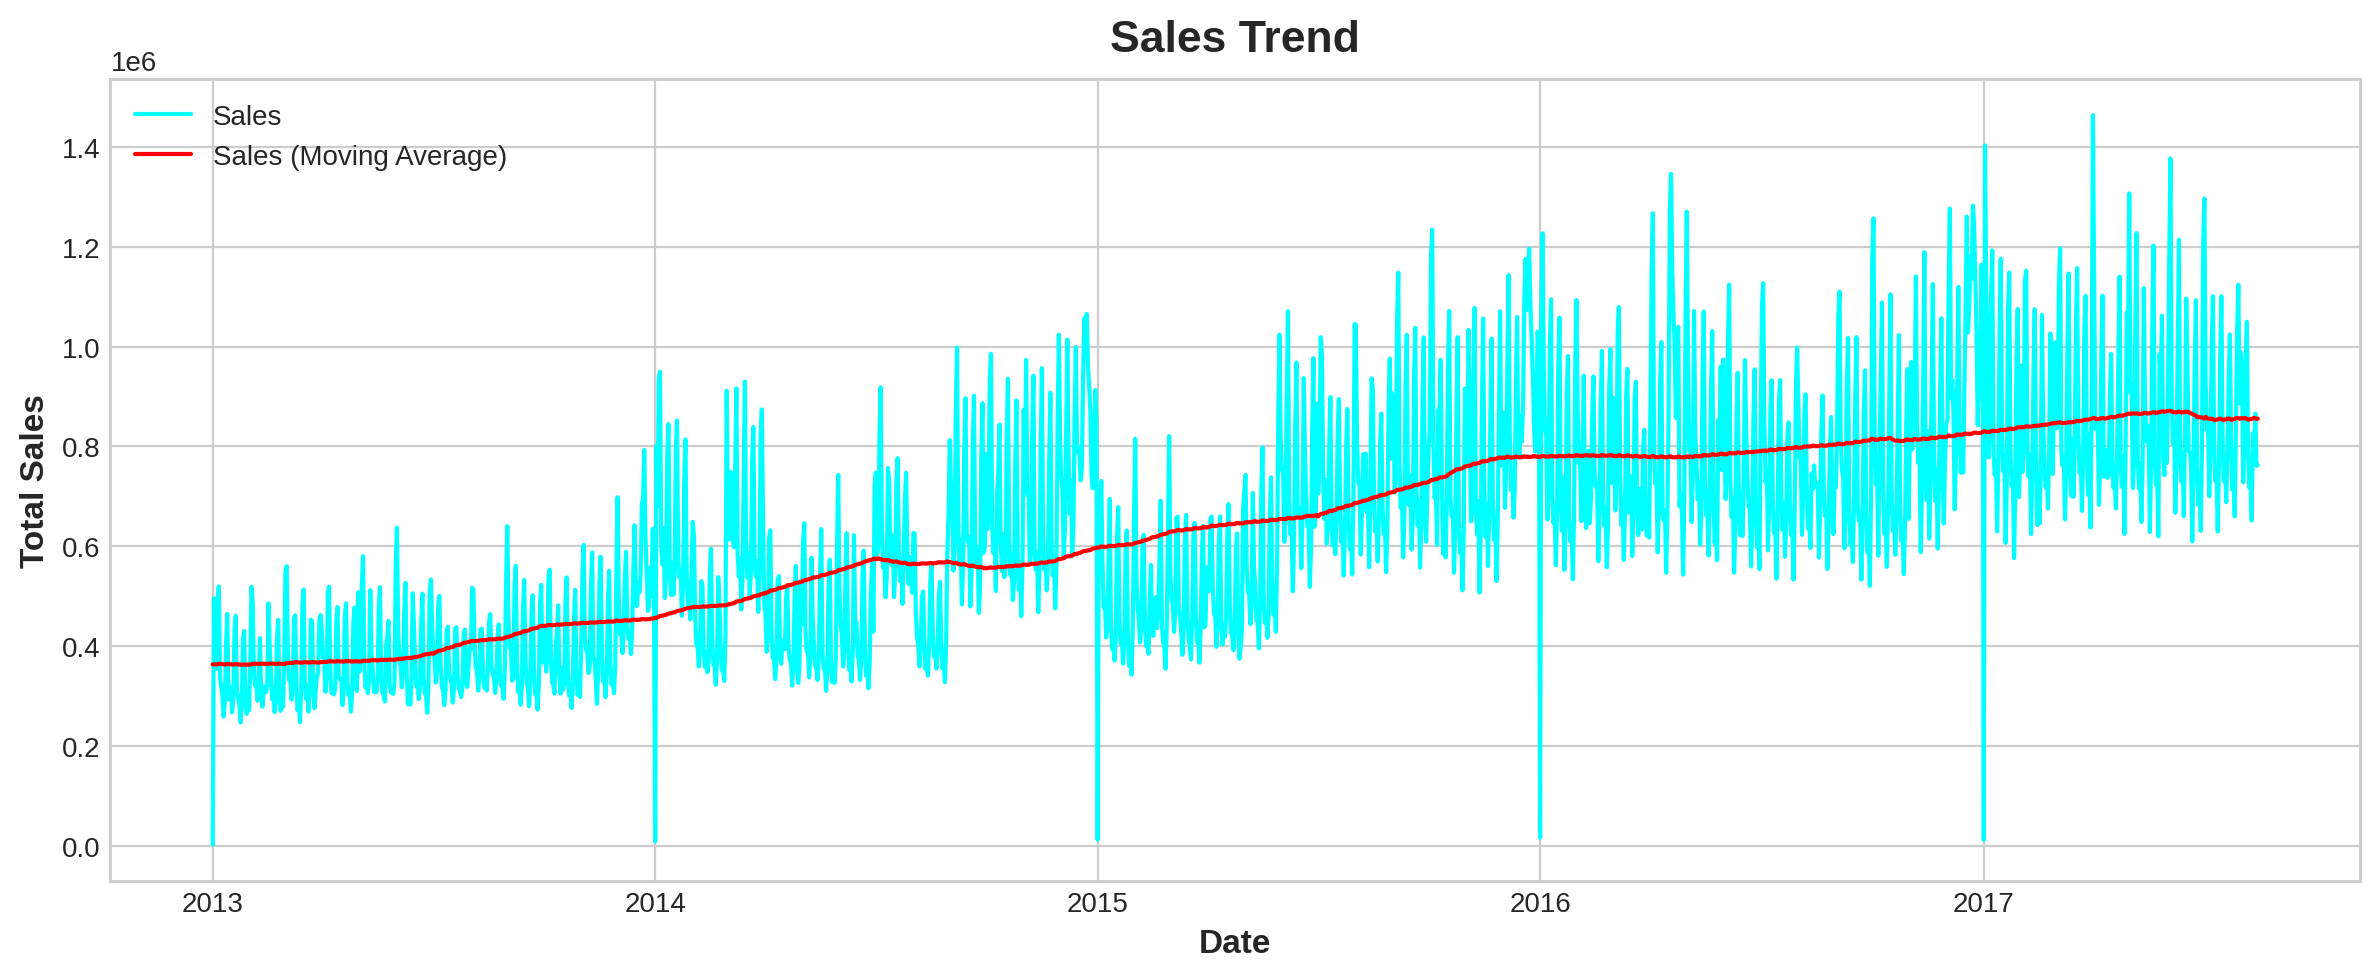

In [49]:
plt.figure(figsize=(12, 5))

plt.plot(df_train.groupby('date').sum()['sales'], color='cyan', label='Sales')
plt.plot(df_train.groupby('date').sum()['sales'].rolling(window=365, center=True, min_periods=183,).mean(), color='red', label='Sales (Moving Average)')

plt.title('Sales Trend')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()

plt.grid(True)
plt.show()

It is possible to see an **increasing trend** of the overall sales in the dataset.

#### Seasonality

Now, let's analyse any **Seasonal** trend in each year. I'll start with **Weekly** analisys.

First I'll use the overall average of the sales per day.

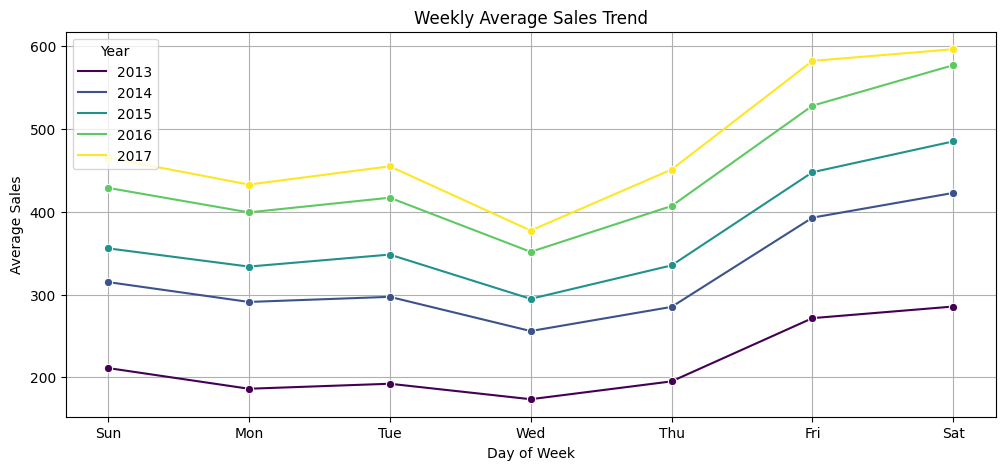

In [40]:
# Temporary Dataframe
temp = df_train.copy() 

# Aggregate by Weekday and Year
temp['weekday'] = temp['date'].dt.dayofweek + 1
temp['year'] = temp['date'].dt.year
weekly_sales = temp.groupby(['year', 'weekday'])['sales'].mean().reset_index()

map_weekday = {1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5:'Thu', 6:'Fri', 7:'Sat'}
weekly_sales['weekday'] = weekly_sales['weekday'].map(map_weekday)


# Plot: Monthly Sales Trends Over Years
plt.figure(figsize=(12, 5))

sns.lineplot(data=weekly_sales, x='weekday', y='sales', hue='year', palette='viridis', marker="o")

plt.title('Weekly Average Sales Trend')
plt.xlabel('Day of Week')
plt.ylabel('Average Sales')
plt.legend(title='Year', loc='upper left', fontsize=10)
plt.grid(True)

Overall, we can see a weekly trend with **higher sales through Fridays and Weekends**.

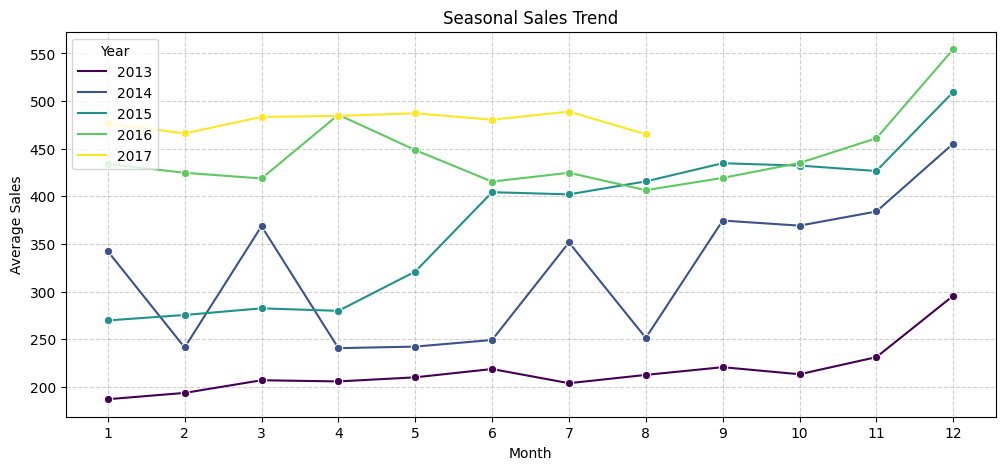

In [19]:
# Temporary Dataframe
temp = df_train.copy() 

# Aggregate by Month and Year
temp['month'] = temp['date'].dt.month
temp['year'] = temp['date'].dt.year
monthly_sales = temp.groupby(['year', 'month'])['sales'].mean().reset_index()

# Plot: Monthly Sales Trends Over Years
plt.figure(figsize=(12, 5))

sns.lineplot(data=monthly_sales, x='month', y='sales', hue='year', palette='viridis', marker="o")

plt.title('Seasonal Sales Trend')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(range(1, 13))
plt.legend(title='Year', loc='upper left', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In each year, we can visualize a increase of sales towards the end of the year.

Now, I'll use the defined functions of **seasonal_plot** and **plot_periodogram** from the Time Series Course ([Seasonality](https://www.kaggle.com/code/ryanholbrook/seasonality)).

In [41]:
#  Time Series Course - Seasonality -> seasonal_plot and plot_periodogram
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

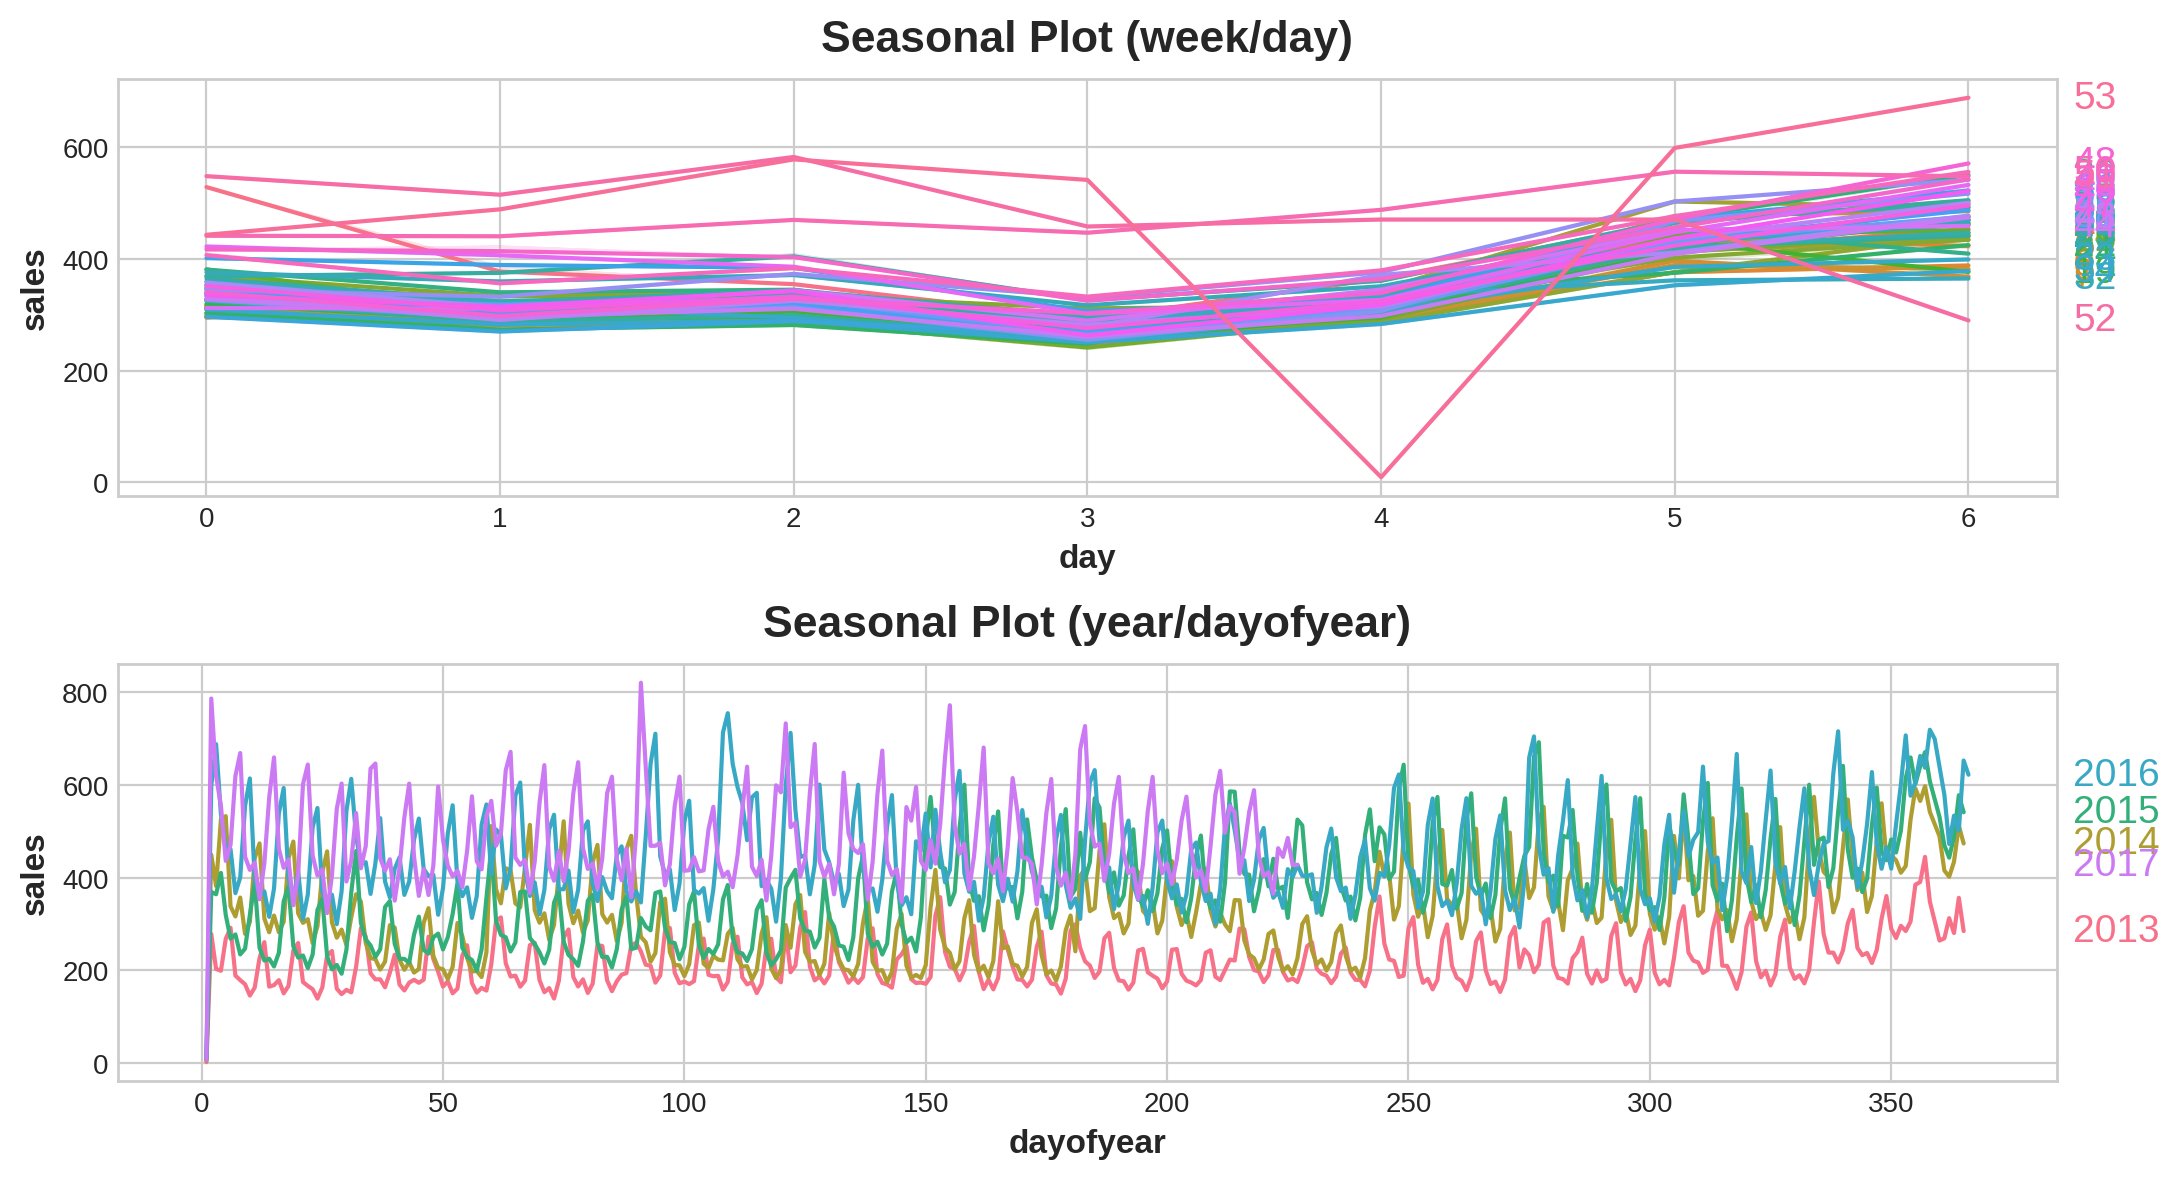

In [46]:
temp = df_train.groupby('date')['sales'].mean().reset_index().set_index('date').to_period("D")

# days within a week
temp["day"] = temp.index.dayofweek  # the x-axis (freq)
temp["week"] = temp.index.week  # the seasonal period (period)

# days within a year
temp["dayofyear"] = temp.index.dayofyear
temp["year"] = temp.index.year

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(temp, y="sales", period="week", freq="day", ax=ax0)
seasonal_plot(temp, y="sales", period="year", freq="dayofyear", ax=ax1);

Most of the Stores follow a seasonal pattern for weeks. From the Annual Seasonal plot, no strong seasonality is apparent.

Let's plot the **periodogram** to see further.

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

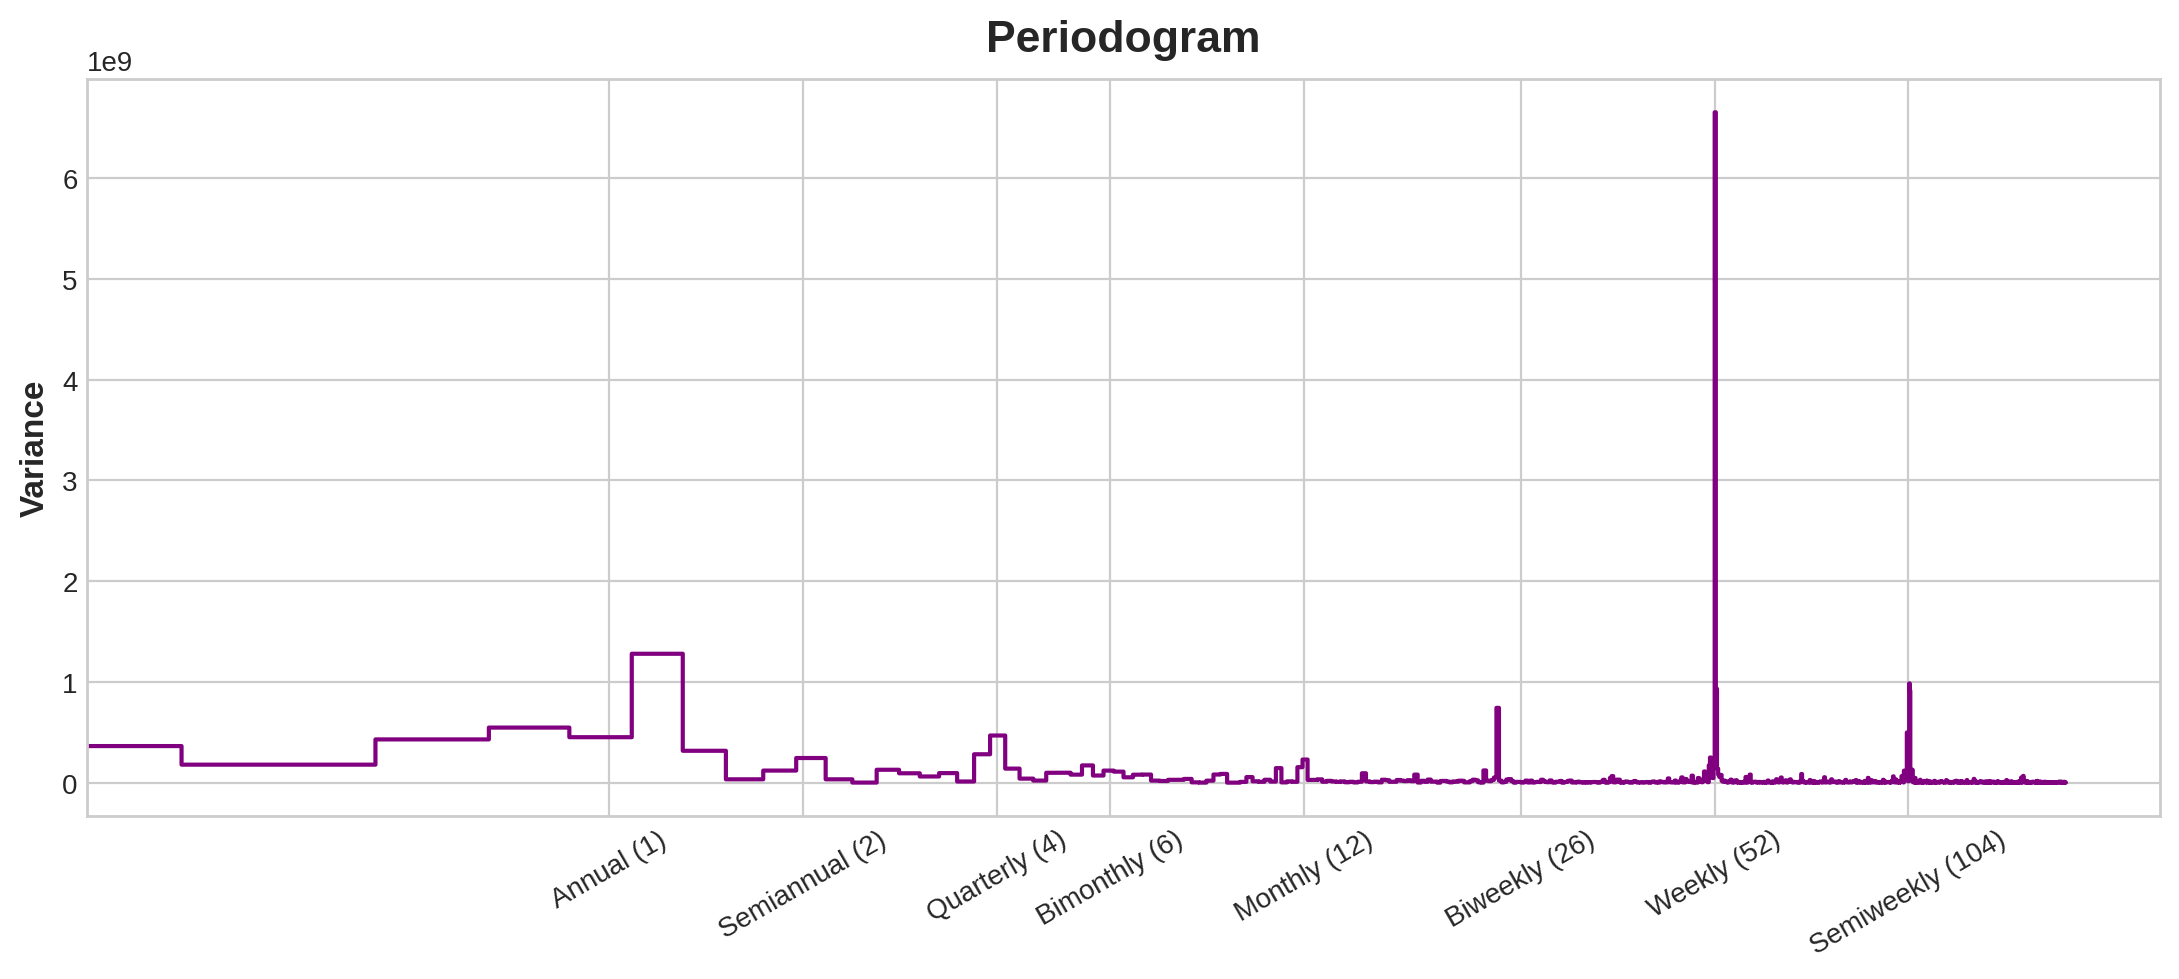

In [48]:
plot_periodogram(df_train.groupby('date')['sales'].sum())

From the periodogram, we shall consider a seasonality features for Weeks, using indicator.

For Annual seasonality, since the periodogram falls between Quaterly and Bimonthly, we shall consider them as the basis for annual seasonality modelling.

#### Cycles

Let's also analyse if any cyclical patterns are found. I'll import the defined functions from Time Series course ([Time Series as Features
](https://www.kaggle.com/code/ryanholbrook/time-series-as-features)): **lagplot** and **plot_lags**.

In [52]:
# Time Series - Time Series as Features -> lagplot and plot_lags 
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

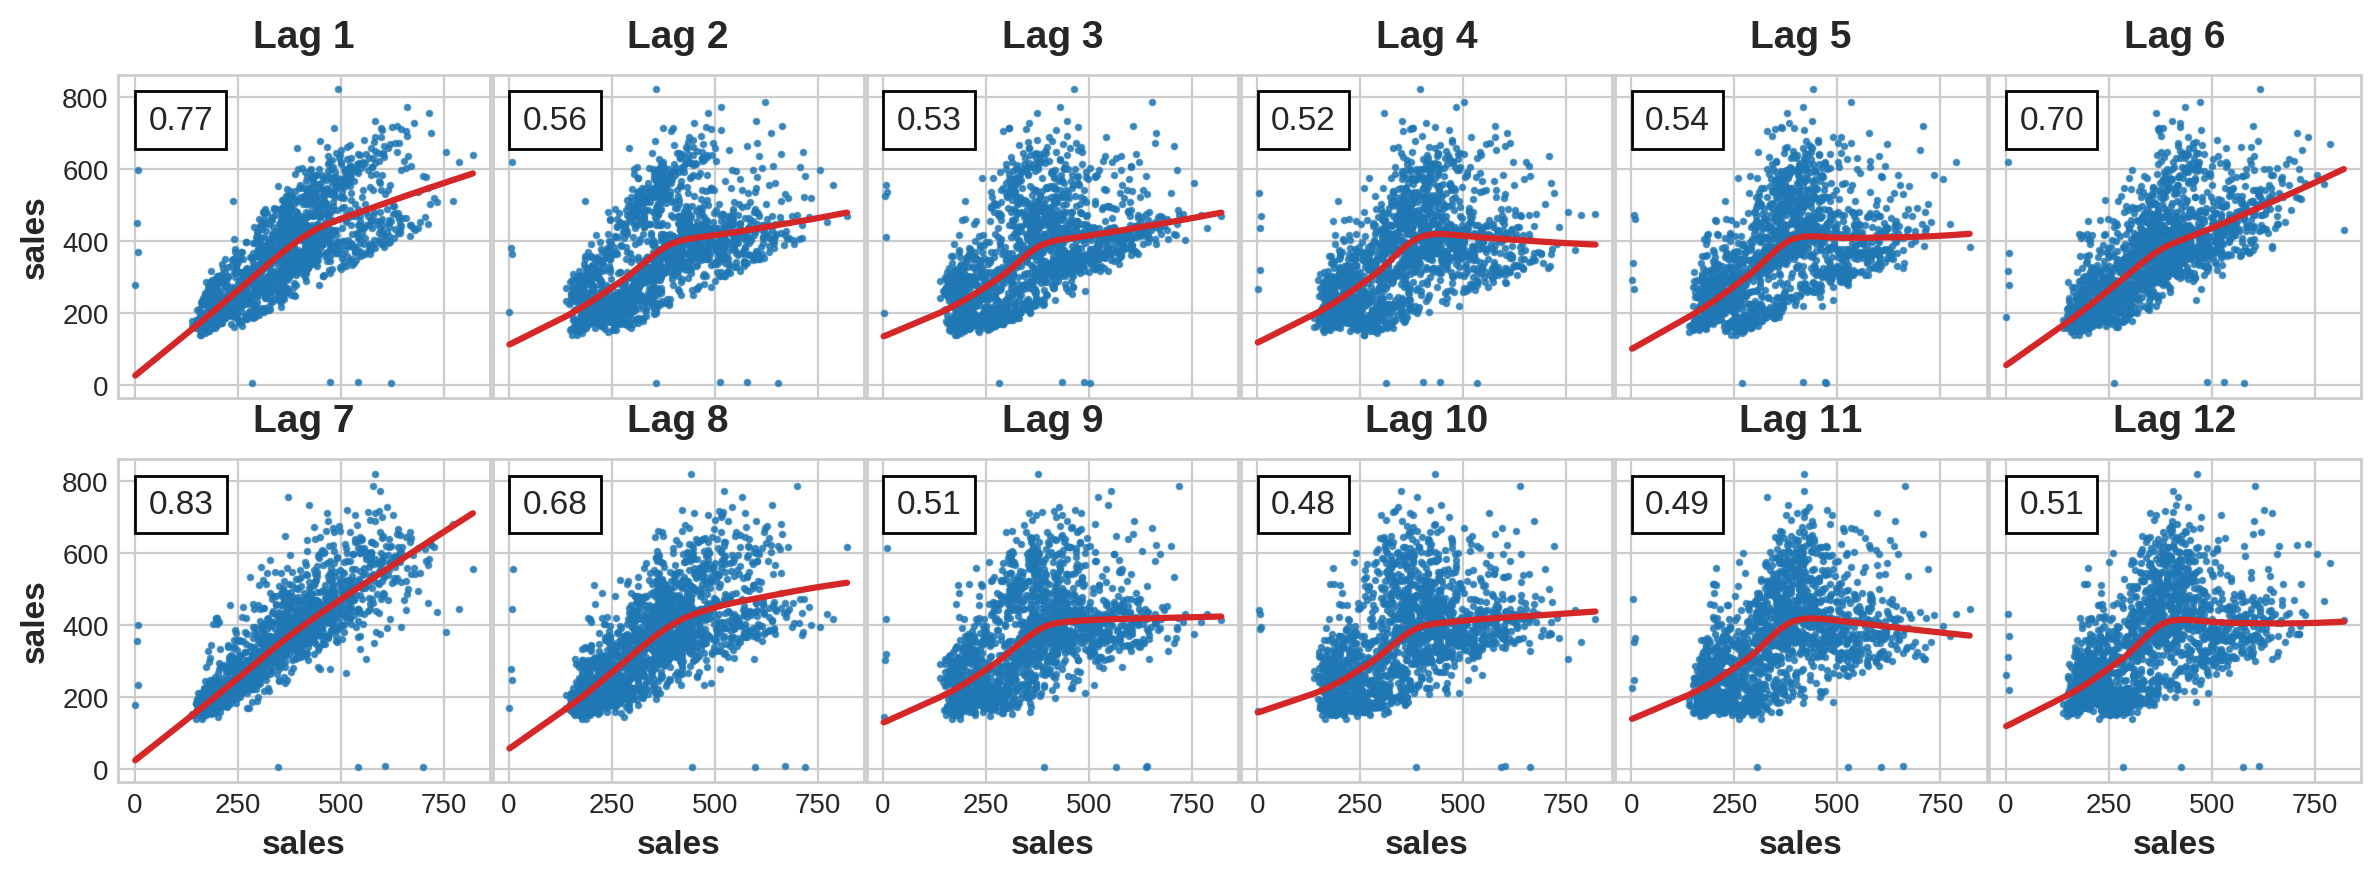

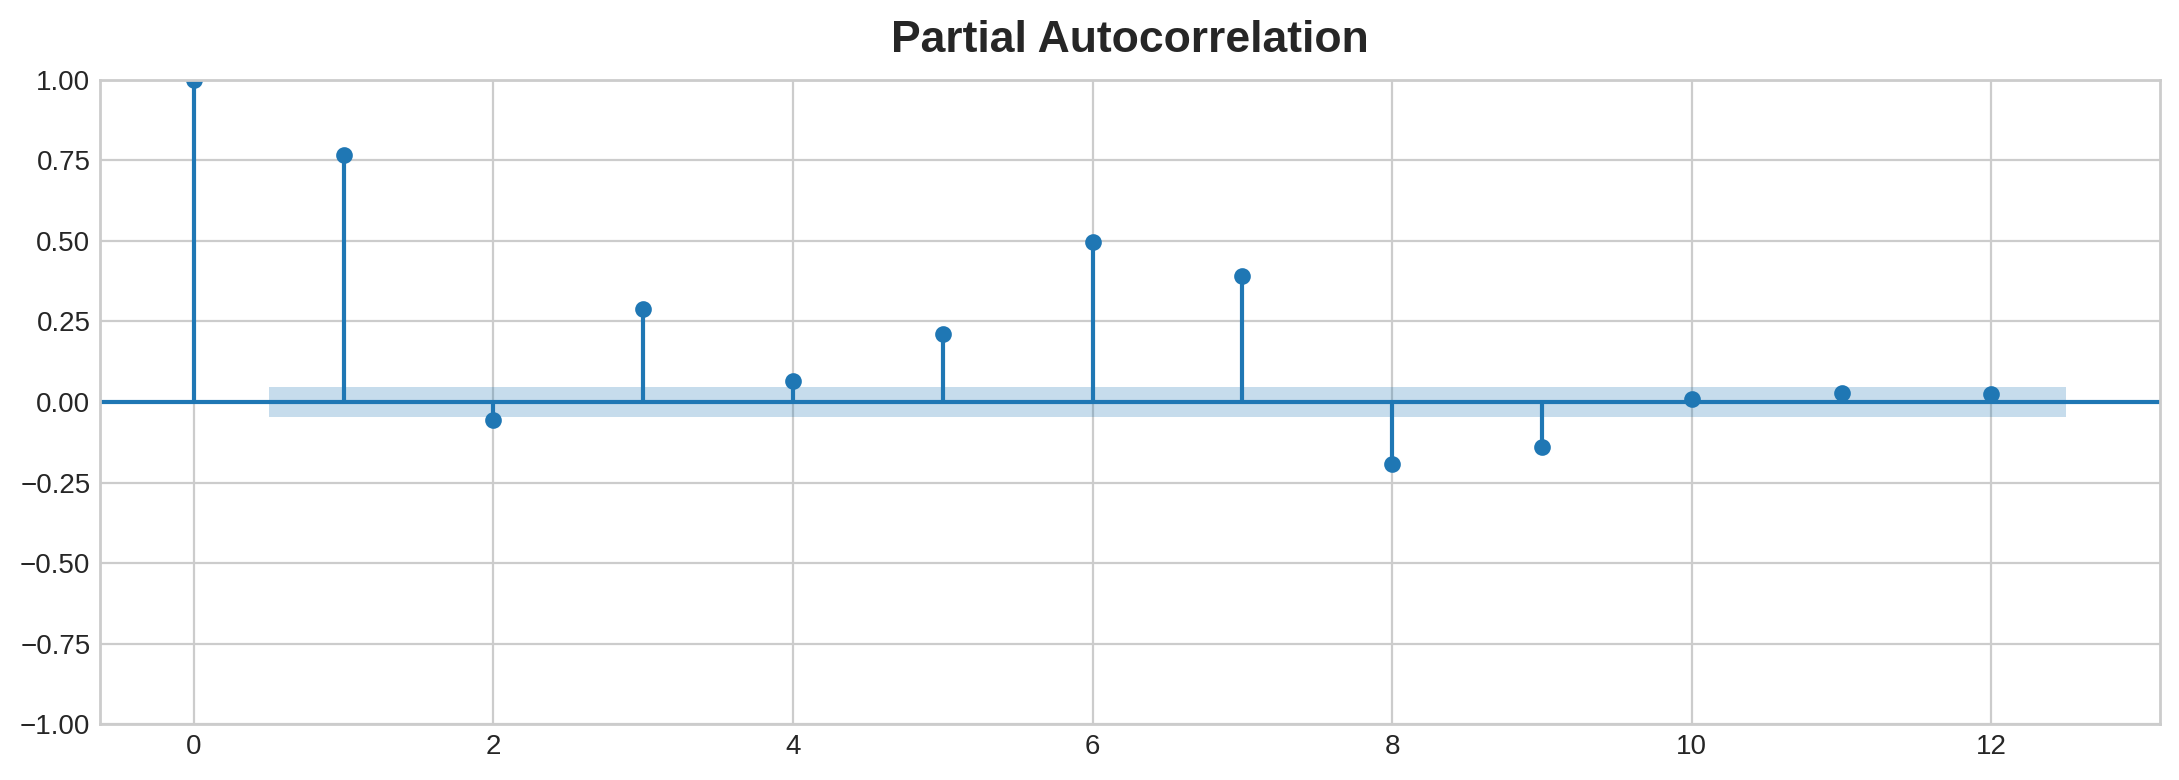

In [54]:
temp = df_train.groupby('date')['sales'].mean().reset_index().set_index('date').to_period("D")

_ = plot_lags(temp.sales, lags=12, nrows=2)
_ = plot_pacf(temp.sales, lags=12)

The **One** (**1**) and **Six** (**6**) days lags have the higher autocorrelation with Sales.

### 2.4 Sales with Store_Nbr, Family and On Promotion

The data is categorized in "**store_nbr**" and "**family**". Let's take a look on it.

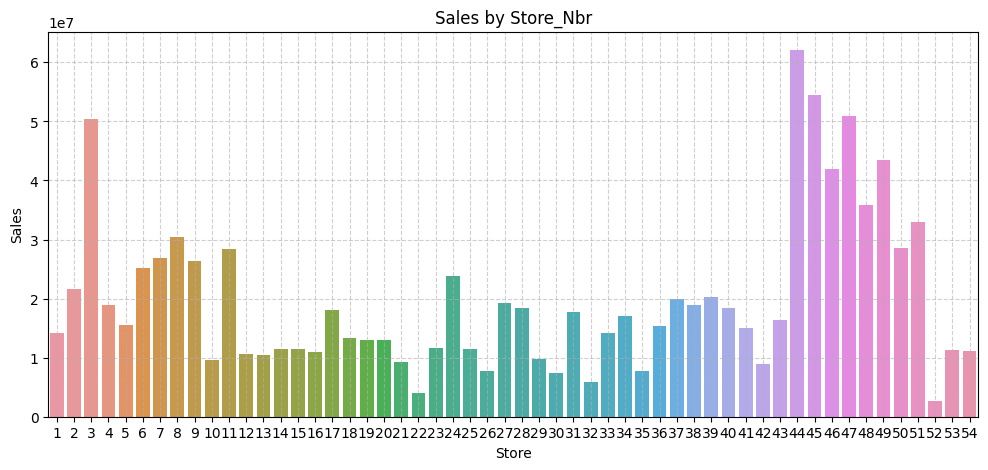

In [21]:
# Aggregate sales by Store_Nbr
temp = df_train.groupby('store_nbr')['sales'].sum().reset_index()

plt.figure(figsize=(12, 5))

#plt.bar(temp['store_nbr'] ,temp['sales'])
sns.barplot(x='store_nbr', y='sales', data=temp.sort_values('sales', ascending=False))

plt.title('Sales by Store_Nbr')
plt.xlabel('Store')
plt.ylabel('Sales')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [22]:
df_train['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

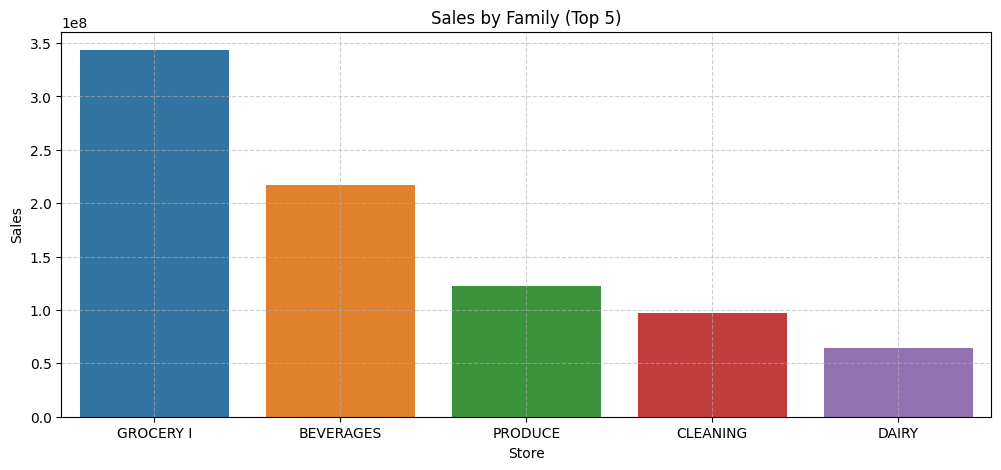

In [23]:
# Aggregate sales by Store_Nbr
temp = df_train.groupby('family')['sales'].sum().reset_index()

plt.figure(figsize=(12, 5))

#plt.bar(temp['store_nbr'] ,temp['sales'])
sns.barplot(x='family', y='sales', data=temp.sort_values('sales', ascending=False).head(5))

plt.title('Sales by Family (Top 5)')
plt.xlabel('Store')
plt.ylabel('Sales')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Let's check if **On Promotion** might affect the number of sales.

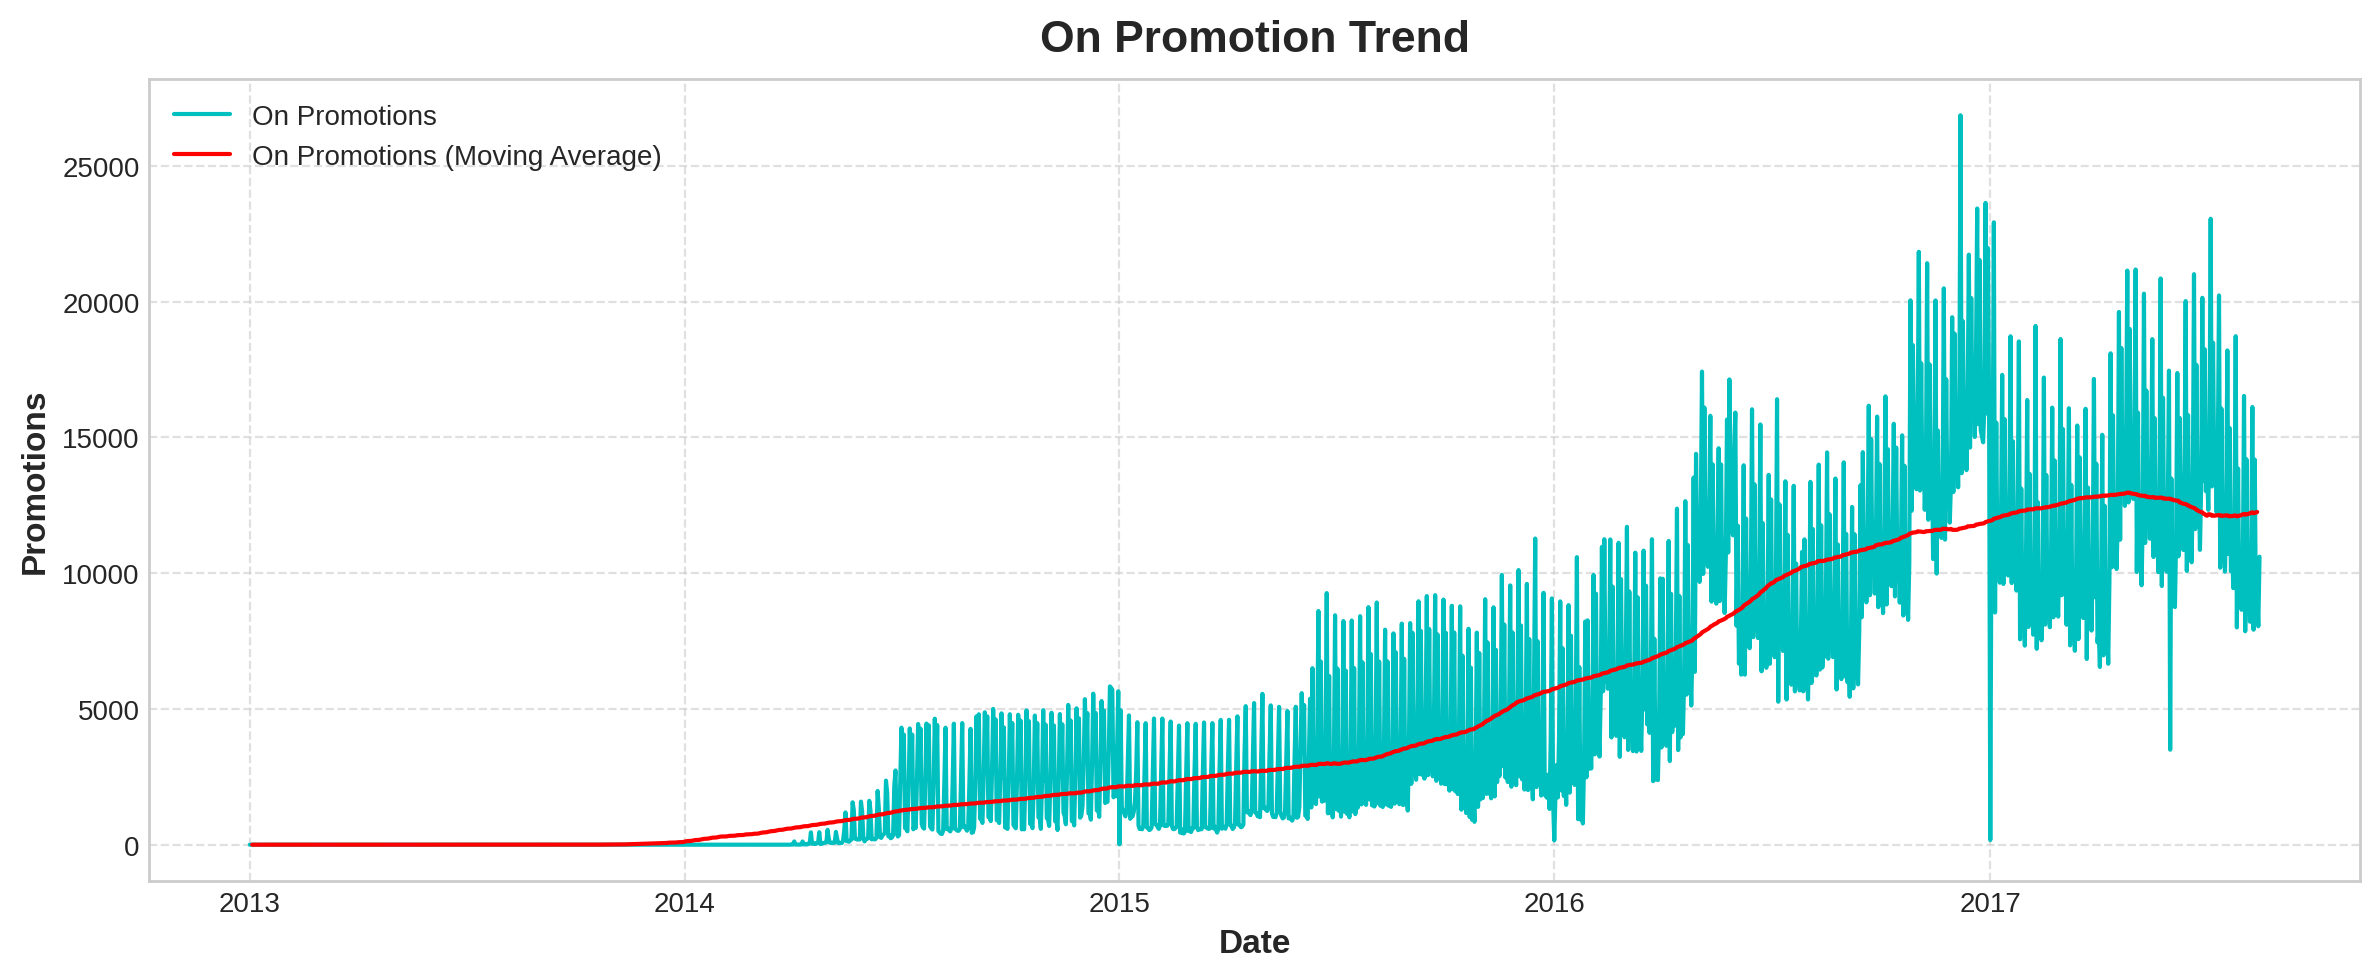

In [50]:
# Aggregate sales by Date
temp_promotion = df_train.groupby('date')['onpromotion'].sum().reset_index()
temp_promotion['onpromotion_avg'] = temp_promotion['onpromotion'].rolling(window=365, center=True, min_periods=185,).mean()
temp_promotion['year'] = temp_promotion['date'].dt.year

plt.figure(figsize=(12, 5))

#plt.bar(temp['store_nbr'] ,temp['sales'])
#sns.lineplot(data=temp_promotion, x='date', y='onpromotion', palette='viridis', marker="o")
#sns.lineplot(data=temp_promotion, x='date', y='onpromotion_avg', palette='viridis', marker="o")

plt.plot(temp_promotion['date'], temp_promotion['onpromotion'], color='c', label='On Promotions')
plt.plot(temp_promotion['date'], temp_promotion['onpromotion_avg'], color='red', label='On Promotions (Moving Average)')

plt.title('On Promotion Trend')
plt.xlabel('Date')
plt.ylabel('Promotions')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [25]:
temp_train = df_train.groupby(["date"]).sales.sum().reset_index()
temp_prom = df_train.groupby(["date"])['onpromotion'].sum().reset_index()
temp = pd.merge(temp_train, temp_prom, how = 'left', on = ['date'])
temp

print("Correlation between Sales and On Promotion: {:,.4f}".format(temp.corr().sales.loc["onpromotion"]))

Correlation between Sales and On Promotion: 0.5749


### 2.5 Sales and Transactions

We'll analyse any correlation between **Sales** and **Transactions**. First we'll analyse **Transactions alone**

In [26]:
df_transactions.head(5)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


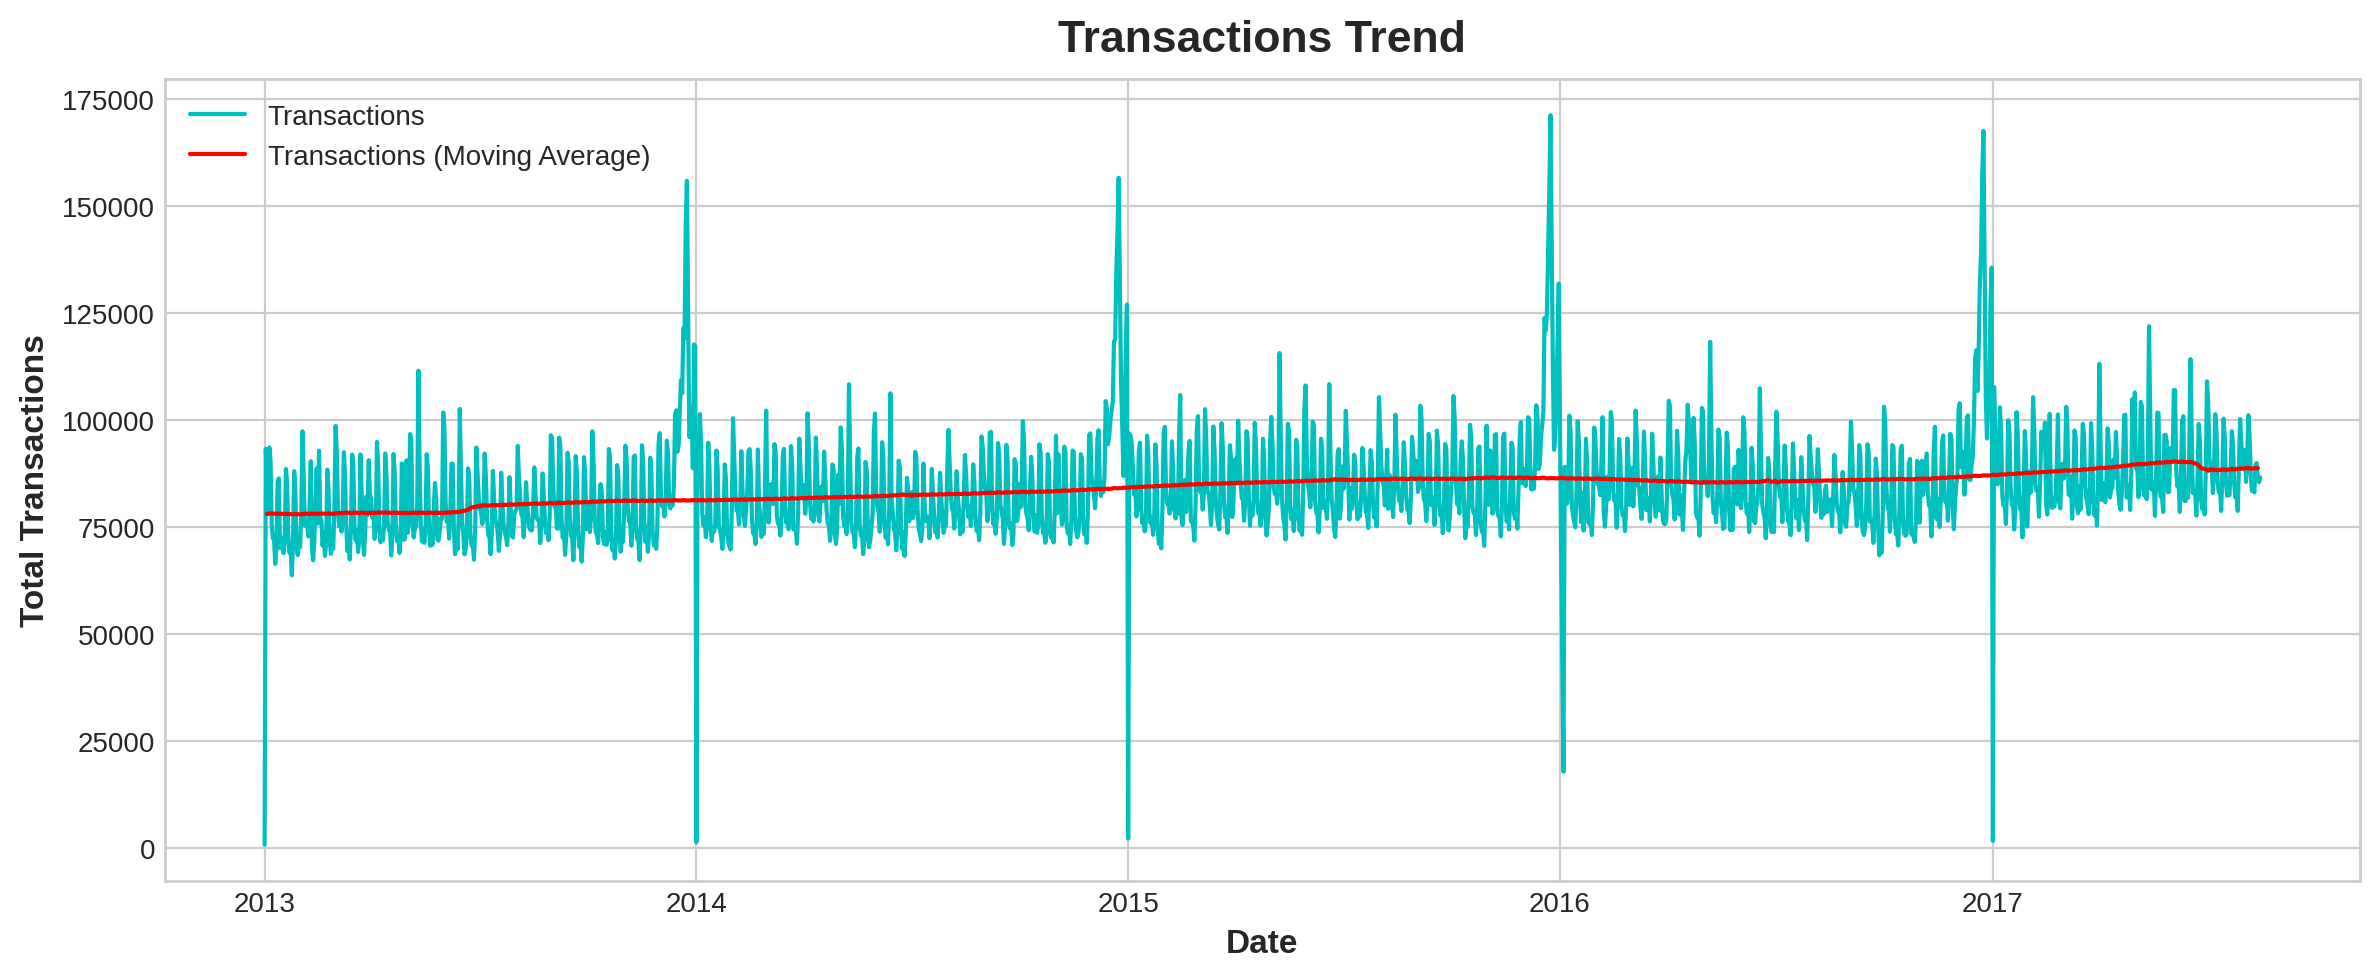

In [51]:
plt.figure(figsize=(12, 5))

plt.plot(df_transactions.groupby('date').sum()['transactions'], color='c', label='Transactions')
plt.plot(df_transactions.groupby('date').sum()['transactions'].rolling(window=365, center=True, min_periods=185,).mean(), color='red', label='Transactions (Moving Average)')

plt.title('Transactions Trend')
plt.xlabel('Date')
plt.ylabel('Total Transactions')
plt.legend()

plt.grid(True)
plt.show()

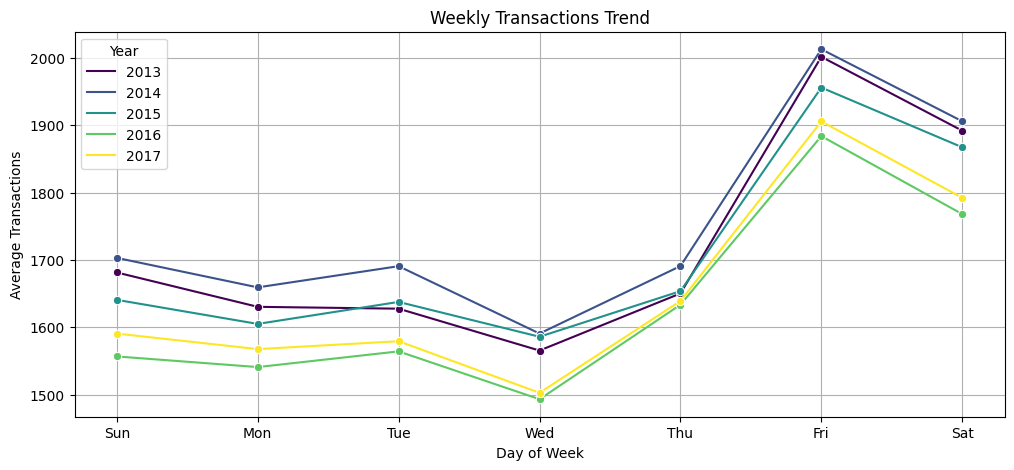

In [29]:
# Temporary Dataframe
temp = df_transactions.copy() 

# Aggregate by Weekday and Year
temp['weekday'] = temp['date'].dt.dayofweek + 1
temp['year'] = temp['date'].dt.year
weekly_sales = temp.groupby(['year', 'weekday'])['transactions'].mean().reset_index()

map_weekday = {1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5:'Thu', 6:'Fri', 7:'Sat'}
weekly_sales['weekday'] = weekly_sales['weekday'].map(map_weekday)


# Plot: Monthly Sales Trends Over Years
plt.figure(figsize=(12, 5))

sns.lineplot(data=weekly_sales, x='weekday', y='transactions', hue='year', palette='viridis', marker="o")

plt.title('Weekly Transactions Trend')
plt.xlabel('Day of Week')
plt.ylabel('Average Transactions')
plt.legend(title='Year', loc='upper left', fontsize=10)
plt.grid(True)

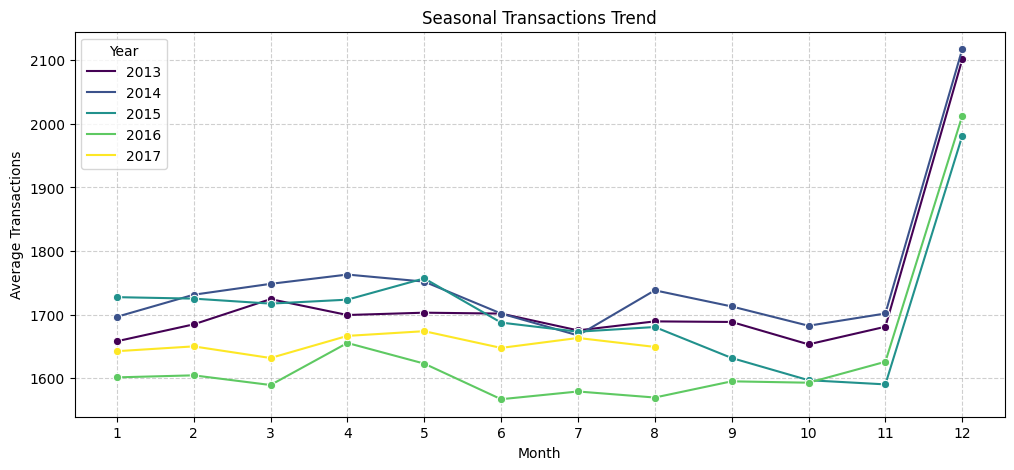

In [28]:
# Temporary Dataframe
temp = df_transactions.copy() 

# Aggregate by Month and Year
temp['month'] = temp['date'].dt.month
temp['year'] = temp['date'].dt.year
monthly_sales = temp.groupby(['year', 'month'])['transactions'].mean().reset_index()

# Plot: Monthly Sales Trends Over Years
plt.figure(figsize=(12, 5))

sns.lineplot(data=monthly_sales, x='month', y='transactions', hue='year', palette='viridis', marker="o")

plt.title('Seasonal Transactions Trend')
plt.xlabel('Month')
plt.ylabel('Average Transactions')
plt.xticks(range(1, 13))
plt.legend(title='Year', loc='upper left', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Transactions seems to follow similar patterns to Sales. For weekly trend, Friday is the peak of transactions.

Now, let's check any correlation between them.

In [30]:
temp_train = df_train.groupby(["date", "store_nbr"]).sales.sum().reset_index()
temp = pd.merge(temp_train, df_transactions, how = 'left', on = ['date', 'store_nbr'])

print("Correlation between Sales and Transactions: {:,.4f}".format(temp.corr().sales.loc["transactions"]))

Correlation between Sales and Transactions: 0.8374


Which gives us a high correlation between them.

### 2.6 Sales and Oil Price

Based on the problem's statement, Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices. We'll check it.

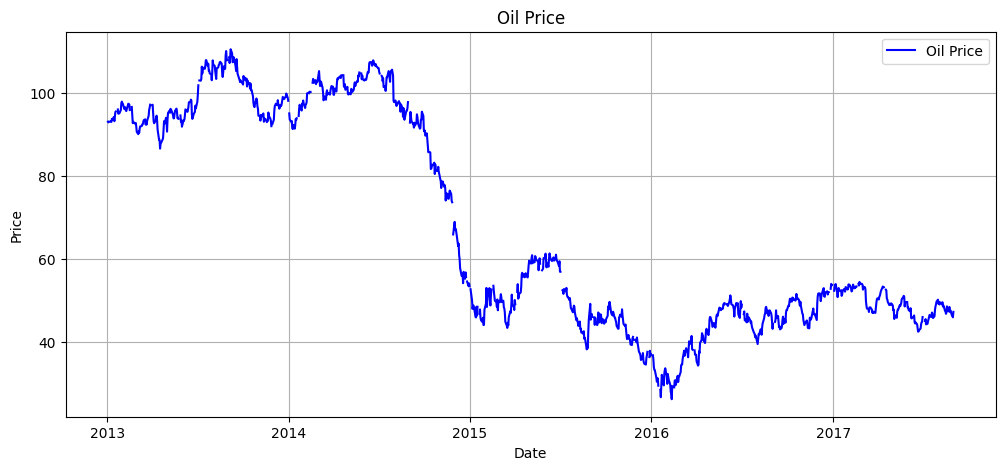

In [31]:
plt.figure(figsize=(12, 5))

plt.plot(df_oil['date'], df_oil['dcoilwtico'], color='blue', label='Oil Price')

plt.title('Oil Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.grid(True)
plt.show()

Seems that there are Nan values. Let's interpolate the missing values.

        date  dcoilwtico  dcoilwtico_interpolated
0 2013-01-01         NaN                      NaN
1 2013-01-02       93.14                93.140000
2 2013-01-03       92.97                92.970000
3 2013-01-04       93.12                93.120000
4 2013-01-05         NaN                93.146667


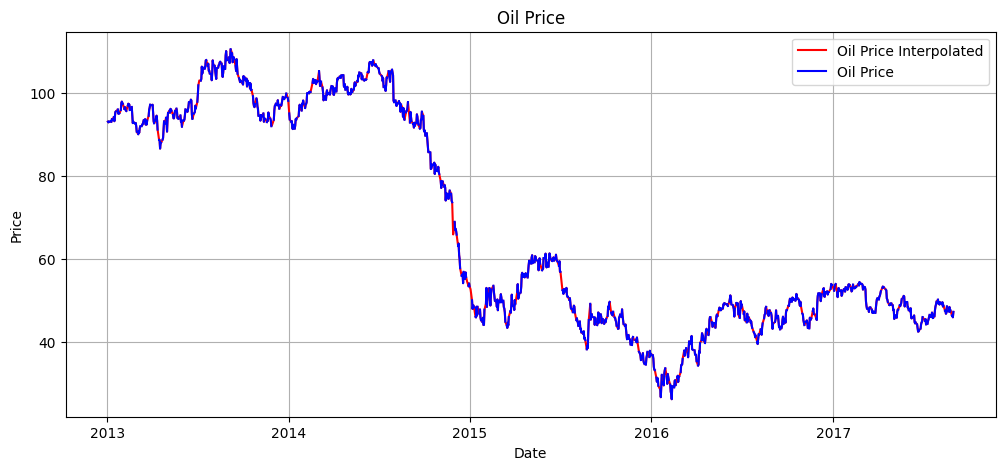

In [32]:
# Interpolate
df_oil = df_oil.set_index("date").dcoilwtico.resample("D").sum().reset_index() #Resample Days (get all days)
df_oil["dcoilwtico"] = np.where(df_oil["dcoilwtico"] == 0, np.nan, df_oil["dcoilwtico"]) #Substitute Zeroes with NaN

df_oil["dcoilwtico_interpolated"] = df_oil.dcoilwtico.interpolate()
print(df_oil.head(5))


plt.figure(figsize=(12, 5))

plt.plot(df_oil['date'], df_oil["dcoilwtico_interpolated"], color='red', label='Oil Price Interpolated')
plt.plot(df_oil['date'], df_oil['dcoilwtico'], color='blue', label='Oil Price')

plt.title('Oil Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.grid(True)
plt.show()

Now, let's check any correlation of **Sales** (and Transactions) with **Oil Price**

Correlation between Sales and Oil Price: -0.6280
Correlation between Transactions and Oil Price: -0.2450


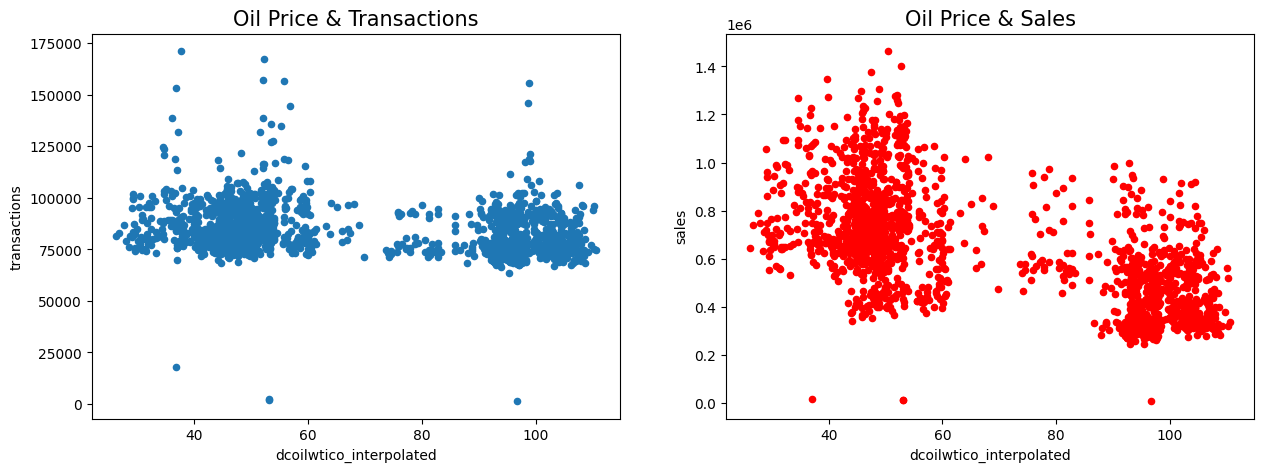

In [33]:
temp_train = df_train.groupby(["date"]).sales.sum().reset_index()
temp_transactions = df_transactions.groupby(["date"]).transactions.sum().reset_index()

temp1 = pd.merge(temp_train, temp_transactions, how = 'left', on = ['date'])

temp = pd.merge(temp1, df_oil, how = 'left', on = ['date'])

#print(temp.head(5))

print("Correlation between Sales and Oil Price: {:,.4f}".format(temp.corr().sales.loc["dcoilwtico_interpolated"]))
print("Correlation between Transactions and Oil Price: {:,.4f}".format(temp.corr().transactions.loc["dcoilwtico_interpolated"]))

fig, axes = plt.subplots(1, 2, figsize = (15,5))
temp.plot.scatter(x = "dcoilwtico_interpolated", y = "transactions", ax=axes[0])
temp.plot.scatter(x = "dcoilwtico_interpolated", y = "sales", ax=axes[1], color = "r")
axes[0].set_title('Oil Price & Transactions', fontsize = 15)
axes[1].set_title('Oil Price & Sales', fontsize = 15);

A strong correlation between Oil Price with Sales and Transactions was not really found. Interestingly, it seems that there are two different cluster forming with 70% as the center. However, looking at the Oil Price trend it seems that late 2014 was a divisive year, since the prices dropped from above 70% to below 70%.

### 2.X Sales and Holiday (On Hold)

We've just analysed Sales with Store_Nbr. Each store is located in a different **City** and **State** which may be affected by **Holidays**. Let's check it.

In [34]:
'''
print(f"type: {df_holidays['type'].unique()}")
print(f"locale: {df_holidays['locale'].unique()}")
print(f"transferred: {df_holidays['transferred'].unique()}")

print(f"locale_name: {df_holidays['locale_name'].unique()}")
print(f"description: {df_holidays['description'].unique()}")
'''

'\nprint(f"type: {df_holidays[\'type\'].unique()}")\nprint(f"locale: {df_holidays[\'locale\'].unique()}")\nprint(f"transferred: {df_holidays[\'transferred\'].unique()}")\n\nprint(f"locale_name: {df_holidays[\'locale_name\'].unique()}")\nprint(f"description: {df_holidays[\'description\'].unique()}")\n'

Let's analyse Holidays related dates with Sales.

In [35]:
'''
# If 'Transfer' is True or 'Work_Day' is True, that day was not a true holiday
true_holidays = df_holidays[(df_holidays.transferred != False) | (df_holidays.type != 'Work Day')]
true_holidays['IsHoliday'] = True

# We must separate by National, Regional (State) and Local (City)
national_holidays = true_holidays[(true_holidays.locale == 'National')]
national_holidays = national_holidays[['date', 'IsHoliday']]

regional_holidays = true_holidays[(true_holidays.locale == 'Regional')]
regional_holidays['state'] = regional_holidays['locale_name']
regional_holidays = regional_holidays[['date', 'state', 'IsHoliday']]

local_holidays = true_holidays[(true_holidays.locale == 'Local')]
local_holidays['city'] = local_holidays['locale_name']
local_holidays = local_holidays[['date', 'city', 'IsHoliday']]

# Let's merge to see which Sales are in Holiday or not
temp = df_train.copy()
print(temp.info())

# First Must Merge
temp = pd.merge(temp, national_holidays, how = "outer", on = ["date"])
#temp = pd.merge(temp, regional_holidays, how = "left", on = ["date", "state"])
#temp = pd.merge(temp, local_holidays, how = "left", on = ["date", "city"])

temp = temp.fillna({'IsHoliday': False})
print(temp.info())

temp2 = temp.groupby(['date', 'IsHoliday'])['sales'].sum()
print(temp2.info())

plt.figure(figsize=(12, 5))

#plt.bar(temp['store_nbr'] ,temp['sales'])
sns.barplot(x='IsHoliday', y='sales', data=temp2.sort_values('sales', ascending=False))

plt.title('Sales by Holiday')
plt.xlabel('Store')
plt.ylabel('Sales')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
'''

'\n# If \'Transfer\' is True or \'Work_Day\' is True, that day was not a true holiday\ntrue_holidays = df_holidays[(df_holidays.transferred != False) | (df_holidays.type != \'Work Day\')]\ntrue_holidays[\'IsHoliday\'] = True\n\n# We must separate by National, Regional (State) and Local (City)\nnational_holidays = true_holidays[(true_holidays.locale == \'National\')]\nnational_holidays = national_holidays[[\'date\', \'IsHoliday\']]\n\nregional_holidays = true_holidays[(true_holidays.locale == \'Regional\')]\nregional_holidays[\'state\'] = regional_holidays[\'locale_name\']\nregional_holidays = regional_holidays[[\'date\', \'state\', \'IsHoliday\']]\n\nlocal_holidays = true_holidays[(true_holidays.locale == \'Local\')]\nlocal_holidays[\'city\'] = local_holidays[\'locale_name\']\nlocal_holidays = local_holidays[[\'date\', \'city\', \'IsHoliday\']]\n\n# Let\'s merge to see which Sales are in Holiday or not\ntemp = df_train.copy()\nprint(temp.info())\n\n# First Must Merge\ntemp = pd.merge(t

## 3. Data Processing

Now that we've already analysed the data. Let's start process the data to prepare for the training. I'll mostly follow the Time Series course from Kaggle.

### 3.1 Trends

Let's create Trends features based on Average Sales per Day

In [36]:
df_train_avg_sales = df_train.groupby('date')['sales'].mean().reset_index().set_index('date').to_period("D")
df_train_avg_sales.head()

,sales
date,
2013-01-01,1.409438
2013-01-02,278.390807
2013-01-03,202.840197
2013-01-04,198.911154
2013-01-05,267.873244


In [37]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp_trend = DeterministicProcess(
    index=df_train_avg_sales.index,
    constant=True,
    order=1,
    drop=True,
)

df_trend = dp_trend.in_sample()
df_trend.head()

,const,trend
date,,
2013-01-01,1.0,1.0
2013-01-02,1.0,2.0
2013-01-03,1.0,3.0
2013-01-04,1.0,4.0
2013-01-05,1.0,5.0


### 3.2 Seasonality